## Preliminary Introduction

With reference to Samson Zhang’s code and 3Blue1Brown’s detailed explanation of Neural Networks, we will build a Neural Network from scratch to predict digits using NumPy, Pandas, and Matplotlib.

The primary focus of this notebook is to develop a deep understanding of the mathematical foundations behind Neural Networks, particularly through the lens of Linear Algebra and Multivariate Calculus. We will rigorously derive key equations for Forward Propagation, Backpropagation, and Gradient Descent, emphasizing concepts such as matrix operations, partial derivatives, and the chain rule.

By the end of this notebook, you will gain a strong intuition for how Neural Networks function beyond just implementation, bridging the gap between theory and practice.

Youtube Links
- Samson Zhang code: https://www.youtube.com/watch?v=w8yWXqWQYmU&t=1745s
- 3Blue1Brown: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi 

Dataset Used: https://www.kaggle.com/c/digit-recognizer/overview

In [33]:
import os

file_directory = 'C:/Users/andyl/OneDrive/Documents/Projects/Digit_Recognition' # change the file_directory accordingly

os.chdir(file_directory)

os.getcwd()

'C:\\Users\\andyl\\OneDrive\\Documents\\Projects\\Digit_Recognition'

## 1. Data Exploration

### 1.1 Importing Libaries and Understanding the Data

The data we are using is the Kaggle "Digit Recognizer" competition dataset. It consists of handwritten digit images, each with a resolution of 28 by 28 pixels.

Each of these pixel corresponds to a neuron in the input layer of our neural network. For every neuron in this input layer, it typically represents a concept -- in this case, the brightness or intensity of the respective pixel in the image. The brighter the pixel, the higher the activation value for the corresponding neuron.

In image representation in computers, grayscale images are typically represented using 8 bits per pixel. This means the activation value of the neuron in the input layer can have integer values between 0 and 255, where 0 represents black (no brightness) and 255 represents white (maximum brightness).

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
data = pd.read_csv('train.csv')

In [36]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
data.max().max()

255

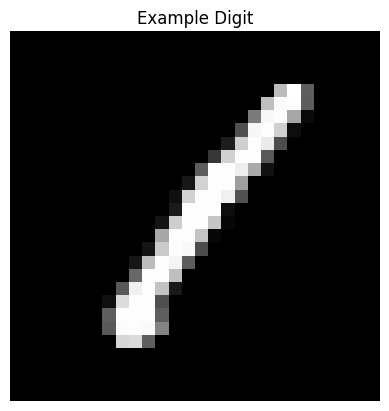

In [38]:
# Display the first image (reshape it to 28x28)
image_data = data.drop(columns = ['label'])
digit_image = image_data.iloc[0].values.reshape(28, 28)

# Plotting the image
plt.imshow(digit_image, cmap='gray')
plt.title("Example Digit")
plt.axis('off')
plt.show()

### 1.2 Normalisation

Normalisation is extremely important in neural network for the following reasons:

**1. Improved Convergence Speed**
- Neural network typically converge faster when the input feature are normalised.If the input values vary widely like 0 to 255 in this case, it makes the optimisation algorithm like gradient descent (will be explained in greater details later) to coverge quickly.

- It prevents the weight $w$'s parameters from updating too much in certain layers, leading to instability in training.

**2. Helps with Activation Function and the Learning Process**
- Normalisation ensures the input to these functions stays within a range where the activation functions (explained in greater details later) behave efficiently

- Normalisation also ensure that all the input features contribute equally to the learning process, rather than having a handful of neurons dominating the learning process

In [39]:
data = np.array(data)
M, N = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:N]
X_test = X_test / 255 # normalise the pixel values

data_train = data[1000:M].T
Y_train = data_train[0]
X_train = data_train[1:N]
X_train = X_train / 255 # normalise the pixel values
_,M_train = X_train.shape 

## 2. Introduction to Neural Network

In the human brain, neurons are the fundamental units responsible for processing and transmitting information.

Similarly in a neural network, we have layers of artifical neurons, where each neuron typically represents a concept. For example, in the case of image recognition, it could represent the brightness of a pixel, or in the case of a Large Language Model like ChatGPT, a neuron could represent a specific topic or feature. 

In this section, we will provide a brief introduction to how neural network operates, from the input layer to the output layer.

### 2.1 Simple Neural Network Illustration

Each neuron has an activation score $a^{(l)}_{j}$ where $l$ represents the $l^{th}$ layer and $j$ represent the $j^{th}$ neuron in that $l^{th}$ layer. 

For each neuron in the $l^{th}$ layer, we connect every neuron to each individual neuron in $(l+1)^{th}$ layer. A weight $w^{(l)}_{k,j}$ is then assigned for each connection, where $k$ represent the $k^{th}$ neuron in the $(l+1)^{th}$ layer. 

Notation can be confusing at first, but it is important to differentiate between each neuron in each layer. Refer to Figure 1 below, which shows all the neurons in the $0^{th}$ layer (the input layer) and a neuron in the $1^{st}$ layer.

- <img src="Figure_1.png" width="250"/>

### 2.2 Activation Function

Using Figure 1 as example, to calculate for $a^{(1)}_{1}$, we calcuate the weighted sum of the $a^{(0)}_{j}$ for all $j$ and we add a bias paramter for inactivity $b^{(1)}_{k}$. This value will then be passed through an activation function, such as sigmoid function or a rectified linear units (ReLU) function.

- Sigmoid Function: produces a value between 0 and 1.
- ReLU: outputs the value directly if it is positive, 0 otherwise. (Refer to Figure 2)

- <img src="Figure_2.png" width="500"/>

In mathematical notation:

$$z^{(1)}_{1} = w^{(0)}_{1,1} \cdot a^{(0)}_{1} + w^{(0)}_{1,2} \cdot a^{(0)}_{2} + ... + w^{(0)}_{1,k} \cdot a^{(0)}_{k} + ... + w^{(0)}_{1,n_{0}} \cdot a^{(0)}_{n_{0}} + b^{(1)}_{1}$$

$$a^{(1)}_{1} = g(z^{(1)}_{1}) \text{ where } g \text{ is the activation function.}$$

### 2.3 Forward Propagation: Mathematical Notation

In general, there are many connections between all neurons in the $l^{th}$ and each neuron in $(l+1)^{th}$ layer (refer to Figure 3). For simplicity and organisation, we use matrices to represent these calculations in an organised manner. 

- <img src="Figure_3.png" width="300"/>

Using Figure 3 as example,

In mathematical notation:

$$
g
\left(
\begin{array}{c}

\left[
\begin{matrix}
w^{(0)}_{1,1} & w^{(0)}_{1,2} & \cdots & w^{(0)}_{1,j} & \cdots & w^{(0)}_{1,n_{0}} \\
\\
w^{(0)}_{2,1} & w^{(0)}_{2,2} & \cdots & w^{(0)}_{2,j} & \cdots & w^{(0)}_{2,n_{0}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
w^{(0)}_{k,1} & w^{(0)}_{k,2} & \cdots & w^{(0)}_{k,j} & \cdots & w^{(0)}_{k,n_{0}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
w^{(0)}_{n_{1},1} & w^{(0)}_{n_{1},2} & \cdots & w^{(0)}_{n_{1},j} & \cdots & \cdots w^{(0)}_{n_{1},n_{0}} \\
\end{matrix}
\right]

\left[
\begin{matrix}
a^{(0)}_{1}\\
\\
a^{(0)}_{2}\\
\vdots \\
a^{(0)}_{j}\\
\vdots \\
a^{(0)}_{n_{0}}\\
\end{matrix}
\right]

+
\left[
\begin{matrix}
b^{(1)}_{1}\\
\\
b^{(1)}_{2}\\
\vdots \\
b^{(1)}_{k}\\
\vdots \\
b^{(1)}_{n_{1}}\\
\end{matrix}
\right]

\end{array}
\right)

= g(\mathbf{W}^{(0)}\mathbf{a}^{(0)} + \mathbf{b^{(1)}})

= g
\left(
\left[
\begin{matrix}
z^{(1)}_{1}\\
\\
z^{(1)}_{2}\\
\vdots \\
z^{(1)}_{k}\\
\vdots \\
z^{(1)}_{n_{1}}\\
\end{matrix}
\right]
\right)

= g(\mathbf{z}^{(1)})

= \left[
\begin{matrix}
a^{(1)}_{1}\\
\\
a^{(1)}_{2}\\
\vdots \\
a^{(1)}_{k}\\
\vdots \\
a^{(1)}_{n_{1}}\\
\end{matrix}
\right]

= \mathbf{a}^{(1)}
$$

$\text{where}: \mathbf{W}^{(0)} \text{ is an } n_{1} \times n_{0} \text{ matrix, } \mathbf{a}^{(0)} \text{ is a column vector of size } n_{0} \text{ , } \mathbf{b}^{(1)} \text{ , } \mathbf{z}^{(1)} \text{ and } \mathbf{a}^{(1)}  \text{ are column vectors of size } n_{1}$

This process is known as **Forward Propagation**. This process will continue through to the last layer $L^{th}$ layer (the output layer), which will provide the output we are interested in predicting.

In this example, for simplicity, we will be working with 3-layer network (further explained in Section 4). Refer to Figure 4.
- The $0^{th}$ layer (input layer) will consist of $n_{0} = 784$ neurons, each representing a pixel. 
- The $1^{st}$ layer will consist of $n_{1} = 10$ neurons, each potentially representing a certain pattern related to the label numbers
- The $2^{nd}$ layer (output layer) will have $n_{2} = 10$ neurons, each representing to a digit from 0 to 9.
- <img src="Figure_4.png" width="300"/>

### 2.4 Softmax Function (Used for Classification Problem)

In classification problem, the softmax function, a normalising **activation function**, is applied to the last layer of a neural network. It converts raw activation scores (logits) into a probability distribution function, ensuring that all output values lies between 0 and 1 and sum to 1.

The softmax activation function $g$ is given by this formula:

$$a^{(L)}_{i} = p_{i} = g(\mathbf{z}^{(L)})_{i} = \dfrac{e^{z^{(L)}_{i}}}{\sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}}} \text{ , notice that } \sum_{i=1}^{n_{L}}{p_{i}} = 1$$

In the case of digit recognition example, we will apply 3-layers neural network (further explained in Section 4), the activation scores in the last layer will be passed through the softmax as such:

$$
\left[
\begin{matrix}
z^{(2)}_{1}\\
z^{(2)}_{2}\\
\vdots \\
z^{(2)}_{10}\\
\end{matrix}
\right]

\xrightarrow{\text{Softmax}}

\left[
\begin{matrix}
a^{(2)}_{1}\\
a^{(2)}_{2}\\
\vdots\\
a^{(2)}_{10}\\
\end{matrix}
\right]

=

\left[
\begin{matrix}
p_{1}\\
p_{2}\\
\vdots\\
p_{10}\\
\end{matrix}
\right]
$$

where $p_{i}$ represents the probability that the digit is $i-1$. The digit corresponding to the highest $p_{i}$ will be our final prediction.


## 3. Fine-Tuning Process

In order to improve the model's performance, we need to optimize the weights and biases parameters of the network. The optimization process involves finding the optimal parameters that minimize the cost function, $C$.

### 3.1 Cost Function

When training any machine learning model, we will always try to minimise the cost function $C$.

There are 2 types of cost functions, for a training data point $m$: 

- For regression problem, we use the Squared Error:

 $$ C_{m}(\mathbf{a}^{(L)}, \mathbf{y})= \sum_{i=1}^{n_{\scriptscriptstyle L}}{(a^{(L)}_{i,m}-y_{i,m})^2} $$

- For classification problem, we use the Cross-Entropy:
$$ C_{m}(\mathbf{a}^{(L)}, \mathbf{y}) = -\sum_{i=1}^{n_{L}}{y_{i,m} \cdot \log{ \left( a^{(L)}_{i,m} \right)}}$$

where $\mathbf{y}$ is a column vector representing the desired activation value for each neuron in the last layer.

To compute the overall cost of $M$ training data points, the total cost function $C$, which is the function we are interested in minimising, is given by the average of the individual costs:

$$ C(\mathbf{A}^{(L)}, \mathbf{Y}) = \dfrac{1}{M}\sum_{m=1}^{M} C_{m}(\mathbf{a}^{(L)}, \mathbf{y}) $$

where $ \mathbf{A}^{(L)} \text{ , } \mathbf{Y} \in \mathbb{R}^{n_{L} \times M} $. The dimension of the matrices and the entries are further illustrated in Section 4, where we apply the concepts to the digit recogniser dataset.

Notice that $\mathbf{a}^{(L)}$ are activation scores derived from the weights and biases parameters in all the previous layers. Therefore the cost function $C$ depends on all the weights $w$ and biases $b$ parameters. 

We want to fine-tune these parameters by minimising $C$. One conventional method is to take the partial derivatives, for example:

$$\dfrac{\partial C}{\partial w^{(l)}_{k,j}} = 0$$

However, we will face 2 major problems: 

1. It is too inefficient to compute all the partial derivatives of all the weights and bias parameters, set them equal to 0, and solve for the optimal parameters.

2. The first derivative test doesn't necessarily guarantee that we will find the minimum value of $C$. While using Hessian matrix is theoretically possible, it is computationally very inefficent, especially for high-dimension problems.

Hence, Machine Learning Engineers and Data Scientists have come up with an ingenious solution by using a concept in Multivariate Calculus,  **Gradient Descent**.


### 3.2 Gradient Descent and its Basis in Multivariate Calculus

#### **Gradient Vector**

In Multivariate Calculus, we have a concept called **gradient vector**. To better understand how gradient vector works, we will first visualise it in a 3-dimension space. (Refer to Figure 5)

Suppose we have a function $z = f(x,y)$, gradient vector is represented by "nabla" or "del" of $f$, $\nabla{f}$, given by this formula.



$$
\nabla{f} = 
\left[
\begin{matrix}
\dfrac{\partial{f}}{\partial{x}}\\
\\
\dfrac{\partial{f}}{\partial{y}}\\
\end{matrix}
\right]
$$

Each component of $\nabla{f}$ represents the rate of change of the function $f(x,y)$ with respective to its corresponding variable. $\dfrac{\partial f}{\partial x}$ tells us how $f$ changes as we move in the $x$-direction in an infinitesimal scale. Similarly, $\dfrac{\partial f}{\partial y}$ tells us how $f$ changes as we move in the $y$-direction in an infinitesimal scale.

<img src="Figure_5.png" width="300"/>

Image used: https://www.math.net/gradient

#### **Directional Derivative**

In Multivariate Calculus, another important concept related to the gradient vector is the **directional derivative** in terms of the gradient of $f$. Essentially, directional derivative $D_{\mathbf{u}}(f)$ measures the rate of change of a function $f(x,y)$ in the direction of a given unit vector $\mathbf{u}$.

The directional derivative is denoted as: 

$$D_{\mathbf{u}}(f) = \nabla{f} \cdot \mathbf{u} \text{ where } \mathbf{u} \text{ is a unit vector i.e } \text{ the magnitude of } \mathbf{u} \text{ , } \lVert \mathbf{u} \rVert = 1$$ 

The directional derivative can be interpreted as the length of the projection of the gradient vector $\nabla{f}$ onto the direction of the unit vector $\mathbf{u}$. Note that $D_{\mathbf{u}}(f)$ is a scalar quantity and $\nabla{f}$ is a vector quantity. (Refer to Figure 6)

Length of projection formula is given by: 

$$proj_{\mathbf{u}}(\nabla{f}) = \dfrac{\nabla{f} \cdot  \mathbf{u}}{\lVert \mathbf{u} \rVert} = \nabla{f} \cdot  \mathbf{u} \text{ since } \lVert \mathbf{u} \rVert  = 1$$ 

<img src="Figure_6.png" width="300"/>


In Figure 6, notice we have a right-angled triangle, so we can establish the following relationship:

$$ cos(\theta) = \dfrac{D_{\mathbf{u}}(f)}{\lVert \nabla{f} \rVert} \implies  D_{\mathbf{u}}(f) = \lVert \nabla{f} \rVert cos(\theta)$$

Since $\lVert \nabla{f} \rVert$ is fixed relative to the point, the rate of change is controlled by $cos(\theta)$. Given that $ -1 \leq cos(\theta) \leq 1$, the maximum rate of change occurs when $cos(\theta) = 1$, which corresponds to $\theta = 0$. This means that the unit vector $\mathbf{u}$ that results in the maximum rate of change of $f$ is in the direction of the gradient vector $\nabla{f}$ itself. 

Therefore, we can conclude that the direction of the gradient vector is the **direction of the steepest ascent**, which indicates the direction in which the function $f$ increases most rapidly. Conversely, moving in the opposite direction, $-\nabla{f}$, is the **direction of the steepest descent**. This principle forms the foundation of **gradient descent**, a key optimisation technique used to minimise the cost function in the most efficient way.

#### **In the context of cost function $C$**

Back to the function we are interested to minimise which is the cost function $C$ by finding the optimal weight and bias parameters.

$$ 
\text{Let }
\mathbf{v} = 
\left[
\begin{matrix}
w^{(0)}_{1,1}\\
\vdots \\
w^{(0)}_{1,n_{0}}\\
\\
b^{(1)}_{1}\\
\vdots \\
b^{(L)}_{n_{L}}\\
\end{matrix}
\right] 

\text{ and }

\nabla{C} = 
\left[
\begin{matrix}
\frac{\partial{C}}{\partial{w^{(0)}_{1,1}}}\\
\vdots \\
\frac{\partial{C}}{\partial{w^{(0)}_{1,n_{0}}}}\\
\\
\frac{\partial{C}}{\partial{b^{(1)}_{1}}}\\
\vdots \\
\frac{\partial{C}}{\partial{b^{(L)}_{n_{L}}}}\\
\end{matrix}
\right]
$$

$\mathbf{v}$ represents the vector of all the weight and bias parameters and $\nabla{C}$ represents the gradient vector of the cost function $C$ with respect to all the weight and bias parameters in the neural network. Since the gradient vector points in the direction of the steepest ascent, we can minimise $C$ by updating the parameters in the opposite direction. Therefore the gradient descent update rule can be written as:

$$\mathbf{v} \leftarrow \mathbf{v} - \alpha\nabla{C}$$

where $\alpha$ is the learning rate, which controls the step size of each update, ensuring that we gradually move towards the optimal parameters rather than overshooting. Selecting an appropriate $\alpha$ is crucial, too large might cause divergence, while too small could slow down convergence.

However, it is important to note that we may not always reach the **global minimum** of the cost function $C$, because the outcome of the gradient descent optimisation process heavily depends on the starting point (the initial values of the weights and biases). 

Referring to Figure 7 below, The optimization algorithm converge to a **local minimum** if we start from point A, but it could converge to the **global minimum** if we start from point B. This is a common challenge in training deep neural networks, especially in high-dimensional spaces where the cost function has multiple minima. Nevertheless, the gradient descent algorithm remains the most efficient of fine-tuning the parameters in practice.

<img src="Figure_7.png" width="500"/>

Image used: https://medium.com/analytics-vidhya/journey-of-gradient-descent-from-local-to-global-c851eba3d367

### 3.3 Backward Propagation

#### **Backward Propagation for the Simplest Network Structure** 

To calculate each entry $\nabla{C}$, we use Backward Propagation, an algorithm that efficiently computes gradients. To fully understand Backward Propagation, we first need to visualise the relationship between the parameters and how they influence the cost function.

We start with the simplest layers network, with one neuron in each layer, as shown in Figure 8.

<img src="Figure_8.png" width="500"/>

First, let's recap the activation score and the notations using Figure 8 as an example:

1. The calculation of the weighted sum and the bias of inactivity (before activation):
$$z^{(L)}_{1} = w^{(L-1)}_{1,1} a^{(L-1)}_{1} + b^{(L)}_{1} $$

2. The activation function $g$ applied to the weighted sum $z$:
$$a^{(L)}_{1} = g(z^{(L)}_{1}) $$

3. The cost function $C$, assuming we only have 1 training data:
- For regression problem:

$$ C(a^{(L)}_{1}, y_{1}) = (a^{(L)}_{1}-y_{1})^2 \implies \dfrac{\partial C}{\partial a^{(L)}_{1}} = 2(a^{(L)}_{1} - y_{1})$$

- For classification problem:

$$ C({a^{(L)}_{1}}, {y}_{1}) = -{y_{1} \cdot \log{ \left( a^{(L)}_{1} \right)}} \implies \dfrac{\partial C}{\partial a^{(L)}_{1}} = -\dfrac{y_{1}}{a^{(L)}_{1}}$$

Note that for equations under points (1) and (2), are structually the same for all layers, the only difference is the indexing.

To compute the entries in $\nabla{C}$, suppose we want to find the partial derivative of $C$ with respect to the weight and bias parameters in the $(L-1)^{th}$ layer, we apply the **Chain Rule**. Notice that:

$$ \dfrac{\partial C}{\partial w^{(L-1)}_{1,1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot \dfrac{\partial a^{(L)}_{1}}{\partial z^{(L)}_{1}} \cdot \dfrac{\partial z^{(L)}_{1}}{\partial w^{(L-1)}_{1,1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot g'(z^{(L)}_{1}) \cdot a^{(L-1)}_{1}$$

$$ \dfrac{\partial C}{\partial b^{(L)}_{1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot \dfrac{\partial a^{(L)}_{1}}{\partial z^{(L)}_{1}} \cdot \dfrac{\partial z^{(L)}_{1}}{\partial b^{(L)}_{1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot g'(z^{(L)}_{1}) \cdot 1$$

$$ \dfrac{\partial C}{\partial a^{(L-1)}_{1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot \dfrac{\partial a^{(L)}_{1}}{\partial z^{(L)}_{1}} \cdot \dfrac{\partial z^{(L)}_{1}}{\partial a^{(L-1)}_{1}} = \dfrac{\partial C}{\partial a^{(L)}_{1}} \cdot g'(z^{(L)}_{1}) \cdot w^{(L-1)}_{1,1} $$

The term $\dfrac{\partial C}{\partial a^{(L-1)}_{1}}$ may not be an entry of $\nabla{C}$, but it plays a crucial role in the **Back Propagation** process for calculating the partial derivative of $C$ with respect to the weights and bias parameters of the previous layer. Suppose now we want to find the partial derivative of $C$ with respect to the weight and bias parameters in the $(L-2)^{th}$ layer. Using the **Chain Rule**,

$$ \dfrac{\partial C}{\partial w^{(L-2)}_{1,1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot \dfrac{\partial a^{(L-1)}_{1}}{\partial z^{(L-1)}_{1}} \cdot \dfrac{\partial z^{(L-1)}_{1}}{\partial w^{(L-2)}_{1,1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot g'(z^{(L-1)}_{1}) \cdot a^{(L-2)}_{1}$$

$$ \dfrac{\partial C}{\partial b^{(L-1)}_{1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot \dfrac{\partial a^{(L-1)}_{1}}{\partial z^{(L-1)}_{1}} \cdot \dfrac{\partial z^{(L-1)}_{1}}{\partial b^{(L-1)}_{1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot g'(z^{(L-1)}_{1}) \cdot 1$$

$$ \dfrac{\partial C}{\partial a^{(L-2)}_{1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot \dfrac{\partial a^{(L-1)}_{1}}{\partial z^{(L-1)}_{1}} \cdot \dfrac{\partial z^{(L-1)}_{1}}{\partial a^{(L-2)}_{1}} = \dfrac{\partial C}{\partial a^{(L-1)}_{1}} \cdot g'(z^{(L-1)}_{1}) \cdot w^{(L-2)}_{1,1}$$

Notice to find the partial derivative of $C$ with respect to the weight and bias parameters in the $(L-2)^{th}$ layer, all of them needs $\dfrac{\partial C}{\partial a^{(L-1)}_{1}}$. Similarly, we use $\dfrac{\partial C}{\partial a^{(L-2)}_{1}}$ to find the partial derivatives of $C$ with respect to the weight and bias parameters in the $(L-3)^{th}$ layer. 

This process continues layer by layer, moving backwards through the network until we reach to the $0^{th}$ layer (input layer). 

So **Forward Propagation** calculates the activations and other values from the input layer to the output layer, **Back Propagation** calculates the gradients for all the parameters from the output layer back to the input layer, using **Chain Rule** to update the weights and bias parameters, ultimately minimising the cost function $C$.


#### **Extending the idea to a general case**

Where we have multiple neurons in the last layer and $M$ number of training data. For a given training data $m$, the cost function is denoted as $C_{m}$ and the partial derivative of the $C_{m}$ with respect to the parameters for the $(L-1)^{th}$ will be the following:

$$ \dfrac{\partial C_{m}}{\partial w^{(L-1)}_{k,j}} = \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot \dfrac{\partial a^{(L)}_{k}}{\partial z^{(L)}_{k}} \cdot \dfrac{\partial z^{(L)}_{k}}{\partial w^{(L-1)}_{k,j}} = \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot g'(z^{(L)}_{k}) \cdot a^{(L-1)}_{j}$$

$$ \dfrac{\partial C_{m}}{\partial b^{(L)}_{k}} = \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot \dfrac{\partial a^{(L)}_{k}}{\partial z^{(L)}_{k}} \cdot \dfrac{\partial z^{(L)}_{k}}{\partial b^{(L)}_{k}} = \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot g'(z^{(L)}_{k}) \cdot 1$$

$$ \dfrac{\partial C_{m}}{\partial a^{(L-1)}_{j}} =\sum_{k=1}^{n_{L}} \left( \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot \dfrac{\partial a^{(L)}_{k}}{\partial z^{(L)}_{k}} \cdot \dfrac{\partial z^{(L)}_{k}}{\partial a^{(L-1)}_{j}} \right) = \sum_{k=1}^{n_{L}} \left( \dfrac{\partial C_{m}}{\partial a^{(L)}_{k}} \cdot g'(z^{(L)}_{k}) \cdot w^{(L-1)}_{k,j} \right) $$

where $j$ and $k$ represents the index for the neurons in $(L-1)^{th}$ and $L^{th}$ layer respectively.

Recall that:

$$z^{(L)}_{k} = w^{(L-1)}_{k,1} \cdot a^{(L-1)}_{1} + w^{(L-1)}_{k,2} \cdot a^{(L-1)}_{2} + ... + w^{(L-1)}_{k,j} \cdot a^{(L-1)}_{j} + ... + w^{(L-1)}_{k,n_{(L-1)}} \cdot a^{(L-1)}_{n_{(L-1)}} + b^{(L)}_{k}$$

$$a^{(L)}_{k} = g(z^{(L)}_{k}) \text{ where } g \text{ is the activation function.}$$

The key difference here is in the 3rd equation, where the parital derivative of $C_{m}$ with respect to the activation $a^{(L-1)}_{j}$ in the $(L-1)^{th}$ layer involves summing over all the neurons in the $L$ layer, as each neuron in the $(L-1)^{th}$ layer contributes to the all the $a^{(L)}_{k}$ for all $1 \leq k \leq n_{L}$ in the $L^{th}$ layer. 

Notice the first 2 equations still remain the same as each weight and bias only directly influences one neuron in layer $L$, meaning no summation is required. **HOWEVER**, depending on the activation function $g$ (e.g Softmax) used, the partial derivative may not be as straightforward, as we will demonstrate in Section 4 later.

Finally, if we want to find the partial derivatives for the overall cost function $C$, using the linearity property of partial differentiation:

$$ \dfrac{\partial C}{\partial w^{(L-1)}_{k,j}} = \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial w^{(L-1)}_{k,j}} $$

$$ \dfrac{\partial C}{\partial b^{(L)}_{k}} = \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial b^{(L)}_{k}} $$

$$ \dfrac{\partial C}{\partial a^{(L-1)}_{j}} = \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial a^{(L-1)}_{j}} $$

The process of **Forward Propagation** and **Back Propagation** will altenate, and this is how neural network gradually learns to optimise/fine-tune its parameters (weights & bias). So the visualisation of the cycle will look like:

***--- Forward Propagation → Cost Calculation → Backpropagation → Update Parameters → Repeat ---***

#### **Partial Derivative of the Activation Function $g$** 

- If function $g$ is the **sigmoid function**, then $g$ and $g'$ are defined as:
$$ g(z) = \dfrac{1}{1 + e^{-z}} \implies g'(z) = \dfrac{e^{-z}}{(1 + e^{-z})^2} $$

- If function $g$ is the **ReLU function**, then $g$ and $g'$ are defined as:
$$ g(z) = 
\begin{cases}
0 & \text{if } z \leq 0 \\
z & \text{if } z > 0
\end{cases}
$$

$$
\implies

g'(z) =
\begin{cases}
0 & \text{if } z \leq 0 \\
1 & \text{if } z > 0
\end{cases}
$$

- If function $g$ is the **Softmax function** (explained in Section 2.4), the derivative will be more complex. In this derivation, we will derive $g$ and $g'$ specifically for the output (last) layer $L$, as the Softmax activation function is typically used for the output layer for classification tasks. $g$ and $g'$ are defined as:

$$ a^{(L)}_{i} = p_{i} = g(\mathbf{z}^{(L)})_{i} = \dfrac{e^{z^{(L)}_{i}}}{\sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}}} $$ 

If $i = j$, then using quotient rule:

$$ \dfrac{\partial g(\mathbf{z}^{(L)})_{i}}{\partial z^{(L)}_{i}} = \dfrac{e^{z^{(L)}_{i}} \cdot \sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}} - e^{z^{(L)}_{i}} \cdot e^{z^{(L)}_{i}}}{\left( \sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}} \right) ^2} = \dfrac{e^{z^{(L)}_{i}} \cdot (\sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}}-e^{z^{(L)}_{i}})}{\left( \sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}} \right) ^2} $$ 

$$ = \dfrac{e^{z^{(L)}_{i}}}{\sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}}} \cdot \left( 1- \dfrac{e^{z^{(L)}_{i}}}{\sum_{k=1}^{n_{L}}{e^{z^{(L)}_{k}}}} \right) $$ 

$$ = a^{(L)}_{i} \cdot \left( 1 - a^{(L)}_{i} \right )  = p_{i} \cdot (1 - p_{i})$$

If $i \neq j$, then:

$$ \dfrac{\partial g(\mathbf{z}^{(L)})_{i}}{\partial z^{(L)}_{j}} = -\dfrac{z^{(L)}_{i}}{\left( \sum_{i=1}^{n_{L}}{e^{z^{(L)}_{i}}} \right) ^2} \cdot e^{z^{(L)}_{j}} $$ 

$$ =  -\dfrac{z^{(L)}_{i}}{\sum_{i=1}^{n_{L}}{e^{z^{(L)}_{i}}}} \cdot \dfrac{z^{(L)}_{j}}{\sum_{i=1}^{n_{L}}{e^{z^{(L)}_{i}}}} $$ 

$$ = - a^{(L)}_{i} \cdot a^{(L)}_{j} = -p_{i} \cdot p_{j} $$

Therefore:

$$
\dfrac{\partial a^{(L)}_{i}}{\partial z^{(L)}_{j}} = 
\dfrac{\partial g(\mathbf{z}^{(L)})_{i}}{\partial z^{(L)}_{j}} =
\begin{cases}
a^{(L)}_{i} \cdot \left( 1 - a^{(L)}_{i} \right ) \text{ , if } i = j \\
\\
- a^{(L)}_{i} \cdot a^{(L)}_{j} = a^{(L)}_{i} \cdot (0 - a^{(L)}_{j}) \text{ , if } i \neq j
\end{cases}

\implies

\dfrac{\partial a^{(L)}_{i}}{\partial z^{(L)}_{j}} = a^{(L)}_{i} \cdot \left( \mathbb{I}(i = j) - a^{(L)}_{j} \right) 

$$

where:
$
\mathbb{I}(i = j) =
\begin{cases}
1 \text{ if } i = j\\
0 \text{ if } i \neq j
\end{cases}
$





For the digit recognition example, we will be using the ReLU function for the hidden layer, and we will use Softmax function for the output layer. 

## 4. Applying the concepts to the Digit Recognition dataset

### 4.1 Understanding the data and its dimension

We consider a 3-layer neural network for digit recognition.

#### **Input Layer ($0^{th}$ layer)** 

- The input layer will have $n_{0} = 784$ neurons corresponding to the 784 pixels in each 28 x 28 input image. 

- For a given training data $m$, we denote the activation scores with a column vector: 

$$\mathbf{a}^{(0)}_{m} \in \mathbb{R}^{n_{0}}$$ 

- For all $M$ training data, the activations are stored as a matrix:

$$\mathbf{A}^{(0)} \in \mathbb{R}^{n_{0} \times M}$$

$$
\mathbf{A}^{(0)}
=
\left[
\begin{matrix}
\mathbf{a}^{(0)}_{1} & \mathbf{a}^{(0)}_{2} & \cdots & \mathbf{a}^{(0)}_{m} & \cdots & \mathbf{a}^{(0)}_{M}
\end{matrix}
\right]
=
\left[
\begin{matrix}
a^{(0)}_{1,1} & a^{(0)}_{1,2} & \cdots & a^{(0)}_{1,m} & \cdots & a^{(0)}_{1,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(0)}_{l,1} & a^{(0)}_{l,2} & \cdots & a^{(0)}_{l,m} & \cdots & a^{(0)}_{l,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(0)}_{784,1} & a^{(0)}_{784,2} & \cdots & a^{(0)}_{784,m} & \cdots & a^{(0)}_{784,M} \\
\end{matrix}
\right]
$$

#### **Hidden Layer ($1^{st}$ layer)** 

- The hidden layer will have $n_{1} = 10$ neurons with ReLU activation function.

- For a given training data $m$, we denote the activation scores with a column vector:

$$\mathbf{a}^{(1)}_{m} \in \mathbb{R}^{n_{1}}$$ 

- For all $M$ training data, the activations are stored as a matrix:

$$\mathbf{A}^{(1)} \in \mathbb{R}^{n_{1} \times M}$$

- The explicit form of $\mathbf{A}^{(1)}$ is similar to $\mathbf{A}^{(0)}$, the only difference is the number of columns.

#### **Output Layer ($2^{nd}$ layer)** 

- The hidden layer will have $n_{2} = 10$ neurons with Softmax activation function, producing a probability distribution over the 10 digit classes (0-9).

- For a given training data $m$, we denote the probability scores with a column vector:

$$\mathbf{a}^{(2)}_{m} \in \mathbb{R}^{n_{2}}$$ 

- For all $M$ training data, the activations are stored as a matrix:

$$\mathbf{A}^{(2)} \in \mathbb{R}^{n_{2} \times M}$$

- The explicit form of $\mathbf{A}^{(2)}$ is similar to $\mathbf{A}^{(0)}$, the only difference is the number of columns.

### 4.2 Forward Propagation Implementation

#### **Input Layer ($0^{th}$ layer)**

- The activation values of the $n_{0} = 784$ neurons in the input layer are stored as a matrix:

$$\mathbf{X} = \mathbf{A}^{(0)} \in \mathbb{R}^{n_{0} \times M}$$

#### **Hidden Layer ($1^{st}$ layer)**

- The weighted sum matrix $\mathbf{Z}^{(1)}$ is denoted: 

$$ \mathbf{Z}^{(1)} = \mathbf{W}^{(0)}\mathbf{X} + \mathbf{b}^{(1)} \mathbf{1}_{M}^{T}$$

where $W^{(0)} \in \mathbb{R}^{n_{1} \times n_{0}} \text{ ; } \mathbf{X} \in \mathbb{R}^{n_{0} \times M} \text{ ; } \mathbf{Z}^{(1)} \text{ , } \mathbf{b}^{(1)} \in \mathbb{R}^{n_{1}}  \text{ ; } \mathbf{1}_{M} \in \mathbb{R}^{M} \text{ , where } \mathbf{1} \text{ is a column vector of ones (of size M) }$

- Note that $\mathbf{1}^{T}$ allows the bias vector $\mathbf{b}^{(1)}$ to be added element-wise to each of column of $\mathbf{W}^{(0)}\mathbf{X}$. It means the bias is broadcasted across the columns, so each column of $\mathbf{Z}^{(1)}$ receive the same bias vector.

- Note that in the code, we donn't explicitly have $\mathbf{1}^{T}$ in the computation. However, NumPy automatically broadcasts the bias vector $\mathbf{b}^{(1)}$ to have the same shape as $\mathbf{W}^{(0)}\mathbf{X}$. This means that $\mathbf{b}^{(1)}$ gets automatically repeated for each of the $M$ columns in $\mathbf{W}^{(0)}\mathbf{X}$

- $ \mathbf{Z}^{(1)}$ is then being passed through the ReLU activation function to obtain the activation scores for the $1^{st}$ layer:

$$ \mathbf{A}^{(1)} = g_{ReLU}(\mathbf{Z}^{(1)}) $$

where $\mathbf{A}^{(1)} \in \mathbb{R}^{10 \times M}$

- Refer to the Section 2.3 Forward Propagation for the explicit matrix computation for one training data.

#### **Output Layer ($2^{nd}$ layer)**

- Analogous to $\mathbf{Z}^{(1)}$, the weighted sum matrix $\mathbf{Z}^{(2)}$ is denoted: 

$$ \mathbf{Z}^{(2)} = \mathbf{W}^{(1)}\mathbf{A}^{(1)} + \mathbf{b}^{(2)} \mathbf{1}_{M}^{T}$$

where $\mathbf{Z}^{(2)} \in \mathbb{R}^{n_{2} \times M} \text{ ; } W^{(1)} \in \mathbb{R}^{n_{2} \times n_{1}} \text{ ; } \mathbf{A}^{(1)} \in \mathbb{R}^{n_{1} \times M} \text{ ; } \mathbf{b}^{(2)} \in \mathbb{R}^{n_{2}} \text{ ; } \mathbf{1}_{M} \in \mathbb{R}^{M} \text{ is a column vector of ones (of size M)}$

- $ \mathbf{Z}^{(2)}$ is then being passed through the Softmax activation function to obtain the probability for the $2^{nd}$ layer:

$$ \mathbf{A}^{(2)} = g_{softmax}(\mathbf{Z}^{(2)}) $$

where $\mathbf{A}^{(2)} \in \mathbb{R}^{10 \times M}$

In [ ]:
def ReLU(Z):
    return np.maximum(Z, 0)

# a function to randomise the weights and the biases parameters
def init_params():
    W0 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W1 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W0, b1, W1, b2

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W0, b1, W1, b2, X):
    Z1 = W0.dot(X) + b1 # Note in Python, even though W0.dot(X) and b1 have different dimension, b1 has the same number of columns as W0.dot(X). NumPy uses broadcasting to align them for the addition and the bias vector b1 gets automically repeated for each of the M columns in W0.dot(X)
    A1 = ReLU(Z1)
    Z2 = W1.dot(A1) + b2 # Same explanation as Z1
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

### 4.3 Backward Propagation Implementation

#### **Preliminary: Indexing and some function**

$i \rightarrow$ dummy index variable

$j \rightarrow$ Index for neurons $1^{st}$ (Hidden) Layer

$k \rightarrow$ Index for neurons $2^{nd}$ (Output) Layer

$\mathbb{I} \rightarrow$ is an indicator function, 1 if True, 0 otherwise


#### **1. Output Layer ($2^{nd}$ layer)**

##### $ \text{ 1a) Matrix } d\mathbf{Z}^{(2)}$

General entry for $d\mathbf{Z}^{(2)}$ is defined as:

$$ \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} 
= \sum_{i = 1}^{10}\left( \dfrac{\partial C_{m}}{\partial a^{(2)}_{i}} \cdot \dfrac{\partial a^{(2)}_{i}}{\partial z^{(2)}_{k}} \right)
= \sum_{i = 1}^{10}\left( -\dfrac{y_{i}}{a^{(2)}_{i}} \cdot a^{(2)}_{i} \cdot \left[\mathbb{I}(i=k) - a^{(2)}_{k} \right] \right) $$

$$ = \sum_{i = 1}^{10} \left( y_{i} \cdot a^{(2)}_{k} \right) -\sum_{i = 1}^{10} \left( y_{i} \cdot \mathbb{I}(i = k) \right) = a^{(2)}_{k} \cdot \sum_{i = 1}^{10}(y_{i}) - y_{k} $$

$$ = a^{(2)}_{k} - y_{k} $$

Note that $\sum_{i = 1}^{10}(y_{i}) = 1$. Since $\mathbf{y}$ is a column vector of desired output, which is 1 for the correct label prediction, 0 for the rest. 

**WARNING**: The activation function $g$ used is the Softmax. Due to the property of Softmax, the parital derivative of $C_{m}$ with respect to the activation $z^{(2)}_{k}$ involves summing over all the neurons in the $2^{nd}$ layer, as $z^{(2)}_{k}$ contributes to all the $a^{(2)}_{i}$ for all $1 \leq i \leq n_{2}$ in the $2^{nd}$ layer.

In matrix form: 

$$ 
d\mathbf{Z}^{(2)} = \mathbf{A}^{(2)} - \mathbf{Y}
$$

where $ d\mathbf{Z}^{(2)} \text{ , } \mathbf{A^{(2)}} \text{ , } \mathbf{Y} \in \mathbb{R}^{n_{2} \times M}$ ($n_{2} = 10$ in this digit recognition example and $M$ is the number of training data.)

In explicit form: 

$$
\left[
\begin{matrix}
\dfrac{\partial C_{1}}{\partial z^{(2)}_{1}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{1}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{1}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{1}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{k}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{k}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{k}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{10}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{10}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{10}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{10}} \\
\end{matrix}
\right]

=
\left[
\begin{matrix}
a^{(2)}_{1,1} & a^{(2)}_{1,2} & \cdots & a^{(2)}_{1,m} & \cdots & a^{(2)}_{1,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(2)}_{k,1} & a^{(2)}_{k,2} & \cdots & a^{(2)}_{k,m} & \cdots & a^{(2)}_{k,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(2)}_{10,1} & a^{(2)}_{10,2} & \cdots & a^{(2)}_{10,m} & \cdots & a^{(2)}_{10,M} \\
\end{matrix}
\right]

-
\left[
\begin{matrix}
y_{1,1} & y_{1,2} & \cdots & y_{1,m} & \cdots & y_{1,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
y_{k,1} & y_{k,2} & \cdots & y_{k,m} & \cdots & y_{k,M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
y_{10,1} & y_{10,2} & \cdots & y_{10,m} & \cdots & y_{10,M} \\
\end{matrix}
\right]
$$


##### $ \text{ 1b) Matrix } d\mathbf{b}^{(2)}$

General entry for $d\mathbf{b}^{(2)}$ is defined as:

$$ \dfrac{\partial C_{m}}{\partial b^{(2)}_{k}} 
= \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} \cdot \dfrac{\partial z^{(2)}_{k}}{\partial b^{(2)}_{k}}
= \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} \cdot 1 
= \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} 
$$

**WARNING**: Previously, in Section 3.3 Back Propagation, the formula for $\dfrac{\partial C}{\partial b^{(L)}_{1}}$ is different. Again, this is due to the fact that the activation function used is Softmax in the $2^{nd}$ layer. As a result, we **cannot** use the formula for $\dfrac{\partial C}{\partial b^{(L)}_{1}}$ shown in Section 3.3 Back Propagation directly, and the Chain Rule in partial differentiation becomes more intricate, similarly to the complexity encountered with the partial derivatives for matrix $d\mathbf{Z}^{(2)}$.

We proceed to find the partial derivative of the overall cost function $C$ with respect to the bias $b^{(2)}_{k}$:

$$ \dfrac{\partial C}{\partial b^{(2)}_{k}} 
= \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial b^{(2)}_{k}}  
= \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}
$$

In matrix form: 

$$ d\mathbf{b}^{(2)} = \dfrac{1}{M} \left( d\mathbf{Z}^{(2)} \mathbf{1}_{M} \right)$$

where $ d\mathbf{Z^{(2)}} \in \mathbb{R}^{n_{2} \times M} \text{ ; } d\mathbf{b}^{(2)} \in \mathbb{R}^{n_{2}}$ ($n_{2} = 10 \text{ ; } \mathbf{1}\in \mathbb{R}^{M} $ in this digit recognition example and $M$ is the size of training data.)

In explicit form:

$$
\left[
\begin{matrix}
\dfrac{\partial C}{\partial b^{(2)}_{1}} \\
\vdots \\
\dfrac{\partial C}{\partial b^{(2)}_{k}} \\
\vdots \\
\dfrac{\partial C}{\partial b^{(2)}_{10}}
\end{matrix}
\right]

= \dfrac{1}{M} \cdot

\left[
\begin{matrix}
\dfrac{\partial C_{1}}{\partial z^{(2)}_{1}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{1}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{1}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{1}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{k}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{k}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{k}} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{10}} & \dfrac{\partial C_{2}}{\partial z^{(2)}_{10}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{10}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{10}} \\
\end{matrix}
\right]

\left[
\begin{matrix}
1 \\
1 \\
\vdots \\
1 \\
\vdots \\
1
\end{matrix}
\right]

$$

#### **2. Hidden Layer ($1^{st}$ layer)**

##### $\text{ 2a) Matrix } d\mathbf{W}^{(1)}$

General entry for $d\mathbf{W}^{(1)}$ is defined as:

$$ \dfrac{\partial C_{m}}{\partial w^{(1)}_{k,j}} 
= \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}  \cdot \dfrac{\partial z^{(2)}_{k}}{\partial w^{(1)}_{k,j}} 
= \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} \cdot a^{(1)}_{j} 
$$

**WARNING**: Same reason as the previous warning, we **cannot** use the formula for $\dfrac{\partial C_{m}}{\partial w^{(1)}_{k,j}}$ shown in Section 3.3 Back Propagation directly.

We proceed to find the partial derivative of the overall cost function $C$ with respect to the bias $w^{(1)}_{k,j}$:

$$ \dfrac{\partial C}{\partial w^{(1)}_{k,j}} = \dfrac{1}{M}\sum_{m=1}^{M} \dfrac{\partial C_{m}}{\partial w^{(1)}_{k,j}} 

= \dfrac{1}{M}\sum_{i=1}^{M} \left( \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}} \cdot a^{(1)}_{j,m} \right)$$

In matrix form:

$$ 
d\mathbf{W}^{(1)} = \dfrac{1}{M} \cdot d\mathbf{Z}^{(2)} \left[ \mathbf{A}^{(1)} \right]^{T} 
$$

where $d\mathbf{W}^{(1)} \in \mathbb{R}^{n_{2} \times n_{1}} \text{ , } d\mathbf{Z^{(2)}} \in \mathbb{R}^{n_{2} \times M} \text{ , } \left[ \mathbf{A}^{(1)} \right]^{T} \in \mathbb{R}^{M \times n_{1}}$ ($n_{1} = 10 \text{ , } n_{2} = 10$ in this digit recognition example and $M$ is the size of training data.)

In explicit form:
$$
\left[
\begin{matrix}
\dfrac{\partial C}{\partial w^{(1)}_{1,1}} & \cdots & \dfrac{\partial C}{\partial w^{(1)}_{1,j}} & \cdots & \dfrac{\partial C}{\partial w^{(1)}_{1,10}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C}{\partial w^{(1)}_{k,1}} & \ \cdots & \dfrac{\partial C}{\partial w^{(1)}_{k,j}} & \cdots & \dfrac{\partial C}{\partial w^{(1)}_{k,10}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C}{\partial w^{(1)}_{10,1}} & \cdots & \dfrac{\partial C}{\partial w^{(1)}_{10,j}} & \cdots & \dfrac{\partial C}{\partial w^{(1)}_{10,10}}
\end{matrix}
\right]

=
\dfrac{1}{M} \cdot

\left[
\begin{matrix}
\dfrac{\partial C_{1}}{\partial z^{(2)}_{1}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{1}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{1}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{k}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{k}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{10}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{10}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{10}} \\
\end{matrix}
\right]

\left[
\begin{matrix}
a^{(1)}_{1,1} & \cdots & a^{(1)}_{1,m} & \cdots & a^{(1)}_{10,1} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(1)}_{1,m} & \cdots & a^{(1)}_{j,m} & \cdots & a^{(1)}_{10,m} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
a^{(1)}_{1,M} & \cdots & a^{(1)}_{j,M} & \cdots & a^{(1)}_{10,M} \\
\end{matrix}
\right]
$$


##### $\text{ 2b) Matrix } d\mathbf{Z}^{(1)}$

General entry for $d\mathbf{Z}^{(1)}$ is defined as:

$$\dfrac{\partial C_{m}}{\partial z^{(1)}_{j}} 
= \sum_{i=1}^{n_{1}} \left( \dfrac{\partial C_{m}}{\partial a^{(1)}_{i}} \cdot \dfrac{\partial a^{(1)}_{i}}{\partial z^{(1)}_{j}} \right)
$$

First, we find:

$$\dfrac{\partial C_{m}}{\partial a^{(1)}_{j}} 
= \sum_{i=1}^{n_{2}} \left( \dfrac{\partial C_{m}}{\partial z^{(2)}_{i}} \cdot \dfrac{\partial z^{(2)}_{i}}{\partial a^{(1)}_{j}} \right)
= \sum_{i=1}^{n_{2}} \left( \dfrac{\partial C_{m}}{\partial z^{(2)}_{i}} \cdot w^{(1)}_{i,j} \right)
= \sum_{i=1}^{n_{2}} \left( w^{(1)}_{i,j} \cdot \dfrac{\partial C_{m}}{\partial z^{(2)}_{i}} \right)
$$

which is the $(j,m)$ entry of the matrix $\left[\mathbf{W}^{(1)} \right]^{T} d\mathbf{Z}^{(2)}$

Now, the activation function $g$ in the $1^{st}$ layer is ReLU function. Therefore,

$$\dfrac{\partial C_{m}}{\partial z^{(1)}_{j}} 
= \dfrac{\partial C_{m}}{\partial a^{(1)}_{j}} \cdot \dfrac{\partial a^{(1)}_{j}}{\partial z^{(1)}_{j}}
= \dfrac{\partial C_{m}}{\partial a^{(1)}_{j}} \cdot g'(z^{(1)}_{j})
$$

$$
= \dfrac{\partial C_{m}}{\partial a^{(1)}_{j}} \cdot \mathbb{I}(z^{(1)}_{j} > 0)
$$

**WARNING**: Note that, because the activation function is ReLU function, $z^{(1)}_{j}$ only contributes to $a^{(1)}_{j}$. Therefore, in this case, the chain rule for partial derivatives holds here.

In matrix form:

$$d\mathbf{Z}^{(1)} = \left[ \mathbf{W}^{(1)} \right]^{T} d\mathbf{Z}^{(2)} \odot g'_{ReLU}(\mathbf{Z}^{(1)})$$

where $\left[ \mathbf{W}^{(1)} \right]^{T} \in \mathbb{R}^{n_{1} \times n_{2}} \text{ ; } d\mathbf{Z}^{(2)} \text{ , } g'_{ReLU}(\mathbf{Z}^{(1)}) \in \mathbb{R}^{n_{2} \times M} \text{ ; } d\mathbf{Z}^{(1)} \in \mathbb{R}^{n_{1} \times M}$ ($n_{1} = 10 \text{ , } n_{2} = 10$ in this digit recognition example and $M$ is the size of training data.) 

Note $\odot$ represents Hadamard product which multiplies corresponding elements.

In explicit form:

$$
\left[
\begin{matrix}
\dfrac{\partial C_{1}}{\partial z^{(1)}_{1}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(1)}_{1}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(1)}_{1}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(1)}_{k}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(1)}_{k}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(1)}_{k}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(1)}_{10}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(1)}_{10}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(1)}_{10}} \\
\end{matrix}
\right]
$$

$$
= 

\left[
\begin{matrix}
w^{(1)}_{1,1} & \cdots & w^{(1)}_{1,k} & \cdots & w^{(0)}_{1,10} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
w^{(1)}_{j,1} & \cdots & w^{(0)}_{j,k} & \cdots & w^{(0)}_{j,10} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
w^{(0)}_{10,1} & \cdots & w^{(0)}_{10,k} & \cdots & \cdots w^{(0)}_{10,10} \\
\end{matrix}
\right]

\left[
\begin{matrix}
\dfrac{\partial C_{1}}{\partial z^{(2)}_{1}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{1}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{1}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{k}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{k}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{k}} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\dfrac{\partial C_{1}}{\partial z^{(2)}_{10}} & \cdots & \dfrac{\partial C_{m}}{\partial z^{(2)}_{10}}& \cdots & \dfrac{\partial C_{M}}{\partial z^{(2)}_{10}} \\
\end{matrix}
\right]

\odot

\left[
\begin{matrix}
\mathbb{I}(z^{(1)}_{1,1} > 0) & \cdots & \mathbb{I}(z^{(1)}_{1,m} > 0) & \cdots & \mathbb{I}(z^{(1)}_{1,M} > 0) \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\mathbb{I}(z^{(1)}_{j,1} > 0) & \cdots & \mathbb{I}(z^{(1)}_{j,m} > 0) & \cdots & \mathbb{I}(z^{(1)}_{j,M} > 0) \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\mathbb{I}(z^{(1)}_{10,1} > 0) & \cdots & \mathbb{I}(z^{(1)}_{10,m} > 0) & \cdots & \mathbb{I}(z^{(1)}_{10,M} > 0) \\
\end{matrix}
\right]

$$

##### $\text{ 2c) Matrix } d\mathbf{b}^{(1)}$

Analogous to $d\mathbf{b}^{(2)}$, the matrix form is defined as:

$$ d\mathbf{b}^{(1)} = \dfrac{1}{M} \left( d\mathbf{Z}^{(1)} \mathbf{1}_{M} \right)$$

where $ d\mathbf{Z^{(1)}} \in \mathbb{R}^{n_{2} \times M} \text{ ; } d\mathbf{b}^{(1)} \in \mathbb{R}^{n_{1}}$ ($n_{1} = 10 \text{ ; } \mathbf{1}\in \mathbb{R}^{M} $ in this digit recognition example and $M$ is the size of training data.)

#### **3. Input Layer ($0^{th}$ layer)**

- $\text{ 3a) Matrix } d\mathbf{W}^{(0)}$

Analogous to $d\mathbf{W}^{(1)}$, the matrix form is defined as:

$$ d\mathbf{W}^{(0)} = \dfrac{1}{M} \cdot d\mathbf{Z}^{(1)} \left[ \mathbf{A}^{(0)} \right]^{T} $$

where $d\mathbf{W}^{(0)} \in \mathbb{R}^{n_{1} \times n_{0}} \text{ , } d\mathbf{Z^{(1)}} \in \mathbb{R}^{n_{1} \times M} \text{ , } \left[ \mathbf{A}^{(0)} \right]^{T} \in \mathbb{R}^{M \times n_{0}}$ ($n_{0} = 784 \text{ , } n_{1} = 10$ in this digit recognition example and $M$ is the size of training data.)

#### **4. Updating the parameters**

Using the idea of Gradient Descent (explained in Section 3.2), we can iteratively fine-tune the parameters to ultimately reduce the overall cost function $C$

$$ \mathbf{b}^{(2)} \leftarrow \mathbf{b}^{(2)} - \alpha \cdot d\mathbf{b}^{(2)} $$
$$ \mathbf{W}^{(1)} \leftarrow \mathbf{W}^{(1)} - \alpha \cdot d\mathbf{W}^{(1)} $$
$$ \mathbf{b}^{(1)} \leftarrow \mathbf{b}^{(1)} - \alpha \cdot d\mathbf{b}^{(1)} $$
$$ \mathbf{W}^{(0)} \leftarrow \mathbf{W}^{(0)} - \alpha \cdot d\mathbf{W}^{(0)} $$

where $\alpha$ represents the step size or the learning rate.

In [ ]:
# essentially produces 1 if True (Z > 0), 0 otherwise
def ReLU_deriv(Z):
    return Z > 0


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W0, W1, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW1 = 1 / M * dZ2.dot(A1.T)
    db2 = 1 / M * np.sum(dZ2, axis = 1, keepdims = True) # axis = 1 means adding the elements by row, keepdims ensure that it is a 2D array with dimension of (10,1)
    dZ1 = W1.T.dot(dZ2) * ReLU_deriv(Z1)
    dW0 = 1 / M * dZ1.dot(X.T)
    db1 = 1 / M * np.sum(dZ1, axis = 1, keepdims = True) # Same explanation as db2
    return dW0, db1, dW1, db2

def update_params(W0, b1, W1, b2, dW0, db1, dW1, db2, alpha):
    W0 = W0 - alpha * dW0
    b1 = b1 - alpha * db1  
    W1 = W1 - alpha * dW1  
    b2 = b2 - alpha * db2  
    return W0, b1, W1, b2

In [42]:
one_hot(Y_train) # shows the probability of the desired outputs Y, which is 1 for the correct label, 0 otherwise

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
# get the highest probability from a probability distribution function that was obtained after passing the activation scores of the last layers.
def get_predictions(A2):
    return np.argmax(A2, 0)

# The proportion of the model correctly identifying the label, out of the total number of training data
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W0, b1, W1, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W0, b1, W1, b2, X)
        dW0, db1, dW1, db2 = backward_prop(Z1, A1, Z2, A2, W0, W1, X, Y)
        W0, b1, W1, b2 = update_params(W0, b1, W1, b2, dW0, db1, dW1, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Accuracy: ", get_accuracy(predictions, Y))
    return W0, b1, W1, b2

### 4.4 Applying the code on the Dataset

In [44]:
W0, b1, W1, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

Iteration:  0
[7 7 7 ... 7 9 7] [5 6 7 ... 0 3 5]
Accuracy:  0.053829268292682926
Iteration:  10
[2 3 0 ... 2 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.19114634146341464
Iteration:  20
[5 3 0 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.26234146341463416
Iteration:  30
[5 6 0 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.324609756097561
Iteration:  40
[5 6 0 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.38426829268292684
Iteration:  50
[5 6 0 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.4411951219512195
Iteration:  60
[6 6 4 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.4949512195121951
Iteration:  70
[6 6 9 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.5387073170731708
Iteration:  80
[6 6 9 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.5790243902439024
Iteration:  90
[6 6 9 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.6120243902439024
Iteration:  100
[6 6 9 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.6386585365853659
Iteration:  110
[6 6 9 ... 0 3 6] [5 6 7 ... 0 3 5]
Accuracy:  0.6618536585365854
Iteration:  120
[6 6 9 

In [45]:
def make_predictions(X, W0, b1, W1, b2):
    _, _, _, A2 = forward_prop(W0, b1, W1, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W0, b1, W1, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W0, b1, W1, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [6]
Label:  6


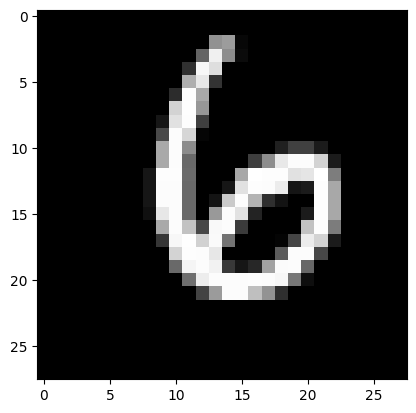

Prediction:  [7]
Label:  7


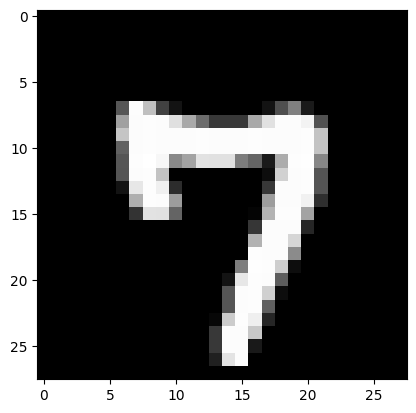

In [46]:
test_prediction(1, W0, b1, W1, b2)
test_prediction(2, W0, b1, W1, b2)

In [47]:
dev_predictions = make_predictions(X_test, W0, b1, W1, b2)
print("Accuracy for the test set: " , get_accuracy(dev_predictions, Y_test))

[8 8 3 4 6 1 1 9 9 0 1 8 0 1 2 0 2 2 6 0 0 7 3 0 5 3 6 1 8 4 3 1 7 9 2 3 5
 9 5 0 7 7 4 4 2 1 7 1 6 1 2 1 4 1 5 0 3 9 8 4 2 5 9 2 3 4 0 2 8 0 7 6 3 1
 2 2 9 6 9 3 2 8 6 9 4 7 9 2 5 1 7 8 1 6 8 8 7 6 2 5 0 2 3 6 1 9 1 3 2 3 8
 4 6 3 4 6 7 9 5 0 0 2 0 9 3 5 8 1 6 1 9 5 6 8 3 6 7 2 4 9 6 1 0 0 3 7 0 7
 1 9 8 2 7 7 1 9 0 4 0 8 5 7 5 4 8 3 7 6 7 9 1 5 8 0 9 1 1 6 1 5 2 3 2 2 1
 7 8 1 7 5 7 1 8 2 2 1 5 4 7 3 1 5 3 6 4 7 1 9 3 6 9 7 9 9 1 7 8 8 8 9 5 5
 8 2 2 6 7 9 2 8 3 4 1 2 2 7 7 3 6 3 1 7 3 3 7 3 5 8 4 6 0 9 1 6 0 0 7 7 8
 7 4 7 7 3 5 7 6 7 1 9 6 9 2 1 5 9 0 1 3 3 0 8 3 9 6 4 7 2 2 9 5 5 0 7 1 1
 1 7 7 6 4 1 0 7 9 8 3 1 1 6 9 2 2 0 8 5 9 9 8 1 2 9 8 0 5 9 6 3 8 5 7 5 5
 9 5 2 3 2 5 0 7 2 4 9 6 1 3 9 2 9 8 5 1 9 5 7 0 6 3 8 9 2 9 0 4 1 2 8 5 3
 9 8 8 4 1 5 1 5 0 9 1 6 6 4 4 8 0 2 6 8 3 1 2 7 6 3 9 1 2 2 7 1 4 3 1 6 7
 8 3 1 7 5 7 0 7 5 5 8 3 7 1 1 7 7 0 5 7 0 3 2 4 6 3 8 3 1 4 1 6 8 6 7 9 7
 0 4 2 9 9 2 8 6 0 3 3 8 5 4 3 4 9 9 7 1 2 8 9 6 7 9 7 2 0 3 3 2 5 6 3 2 2
 4 2 9 0 0 2 8 3 0 3 5 2 

The Neural Network model achieves approximately 85% accuracy on both the training and test datasets. This indicates that the model neither overfits nor underfits the data. Instead, it generalizes well, meaning it performs consistently across both seen (training) and unseen (test) data.